## 데이터 전처리

In [27]:
import pandas as pd
import numpy as np

stations = pd.read_csv("dataset/usage_stations.csv", index_col=False)
time = pd.read_csv("dataset/usage_time.csv")
day = pd.read_csv("dataset/usage_day.csv")
month = pd.read_csv("dataset/usage_month.csv")

In [28]:
# 필요없는 열 제거 (통계 분석에 무의미한 열 제거)
stations = stations[['station_id','gu', 'latitude','longitude','installed','qr','lcd','bike_type']]
"""
대여소 이름도 문자열 처리해서 아파트 앞, 역 앞 등을 확인해서 분석하고 싶지만, geojson 데이터 등
대여소가 이름대로 정말 특정한 시설과 가까운지 확인할 방법이 현재 존재하지 않아 과감하게 제외했습니다.
"""
time = time[[
    'date', 'hour','station_id','rental_type','gender','age','rentals',
    'calories', 'carbon_reduction', 'distance'
]]
day = day[[
    'date','station_id','rental_type','gender','age','rentals',
    'calories', 'carbon_reduction', 'distance', 'time'
]]
month = month[[
    'date','station_id','rental_type','gender','age','rentals',
    'calories', 'carbon_reduction', 'distance', 'time'
]]


In [29]:
# 결측치, 이상치 처리
stations.fillna(0, inplace=True)

for dataset in [time, day, month]:
    dataset['gender'] = dataset['gender'].fillna('unknown')
    dataset['gender'] = dataset['gender'].replace("m", "M")
    dataset['gender'] = dataset['gender'].replace("f", "F")
    dataset['age'] = dataset['age'].replace("~10대", "10대 이하")
    dataset[['calories', 'carbon_reduction']] = dataset[['calories', 'carbon_reduction']].fillna(0)

In [30]:
# 결측치 처리 확인
for dataset in [stations, time, day, month]:
    print(dataset.isna().sum())
    print("="*20)

station_id    0
gu            0
latitude      0
longitude     0
installed     0
qr            0
lcd           0
bike_type     0
dtype: int64
date                0
hour                0
station_id          0
rental_type         0
gender              0
age                 0
rentals             0
calories            0
carbon_reduction    0
distance            0
dtype: int64
date                0
station_id          0
rental_type         0
gender              0
age                 0
rentals             0
calories            0
carbon_reduction    0
distance            0
time                0
dtype: int64
date                0
station_id          0
rental_type         0
gender              0
age                 0
rentals             0
calories            0
carbon_reduction    0
distance            0
time                0
dtype: int64


## 데이터 시각화

In [31]:
# library 준비
import matplotlib.pyplot as plt
from matplotlib import rcParams
import seaborn as sns

import scipy.stats as spst
from statsmodels.graphics.mosaicplot import mosaic
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV, train_test_split, cross_val_score
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.tree import DecisionTreeRegressor, DecisionTreeClassifier, plot_tree
from sklearn.neighbors import KNeighborsRegressor, KNeighborsClassifier
from sklearn.svm import SVR, SVC
from sklearn.metrics import *
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier

rcParams["font.family"] = "Malgun Gothic"   # 한글 폰트
rcParams["axes.unicode_minus"] = False      # 마이너스 기호 깨짐 방지

palette = [
    "#c63a39",
    "#f67148",
    "#e6d412",
    "#5dc9bc",
    "#269489",
    "#08a2e3",
    "#3d5965",
    "#ffffff",  # white
    "#000000",  # black
    "#a2a2a2",  # gray (기타 추천)
]

C:\Users\Public\Documents\ESTsoft\CreatorTemp\ipykernel_25248\2564367522.py:32: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend(loc='upper right')


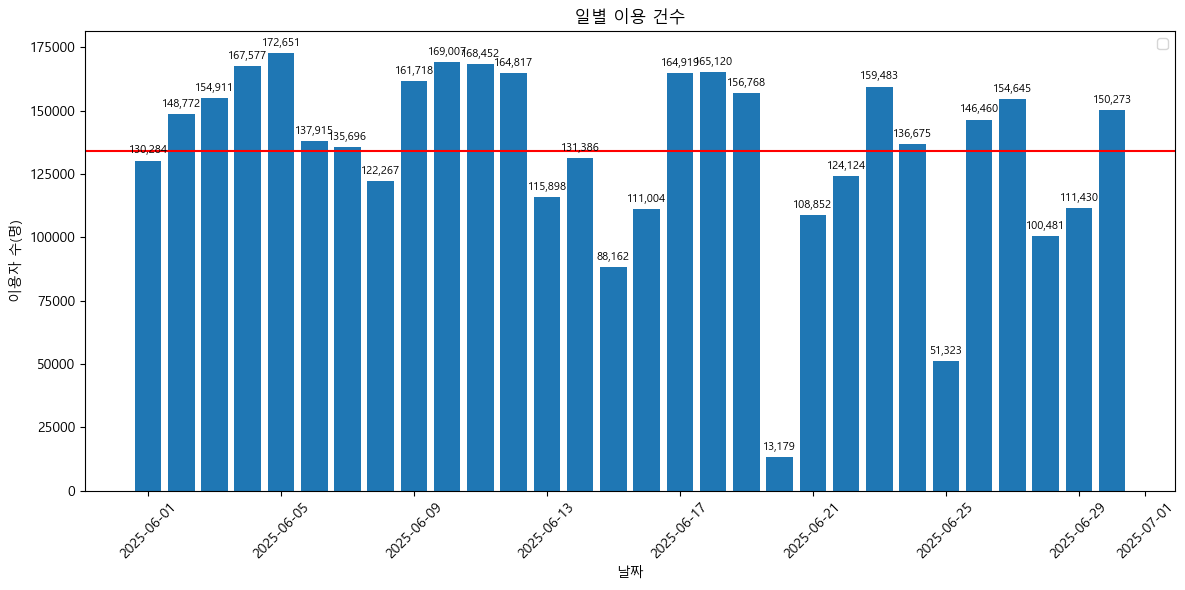

In [ ]:
"""일별 이용자 수"""

x_col = "date"
count_col = "rentals"

df = time.copy()

# ===== 날짜 파싱 =====
df[x_col] = pd.to_datetime(df[x_col], errors="coerce")


# ===== 일별 이용건수 =====
daily = (
    df.groupby(df[x_col].dt.date)[count_col]
    .sum()
    .rename("rentals")
    .reset_index()
    .rename(columns={x_col: "date"})
)

# ===== 시각화 =====
fig, ax = plt.subplots(figsize=(12, 6))
bars = ax.bar(daily["date"], daily["rentals"])

ax.bar_label(bars, labels=[f"{v:,}" for v in daily["rentals"]], padding=3, fontsize=8)

plt.xticks(rotation=45)
plt.xlabel("날짜")
plt.ylabel("이용자 수(명)")
plt.legend(loc='upper right')
plt.title("일별 이용 건수")
plt.axhline(daily["rentals"].mean(), color='red')
plt.tight_layout()
plt.show()



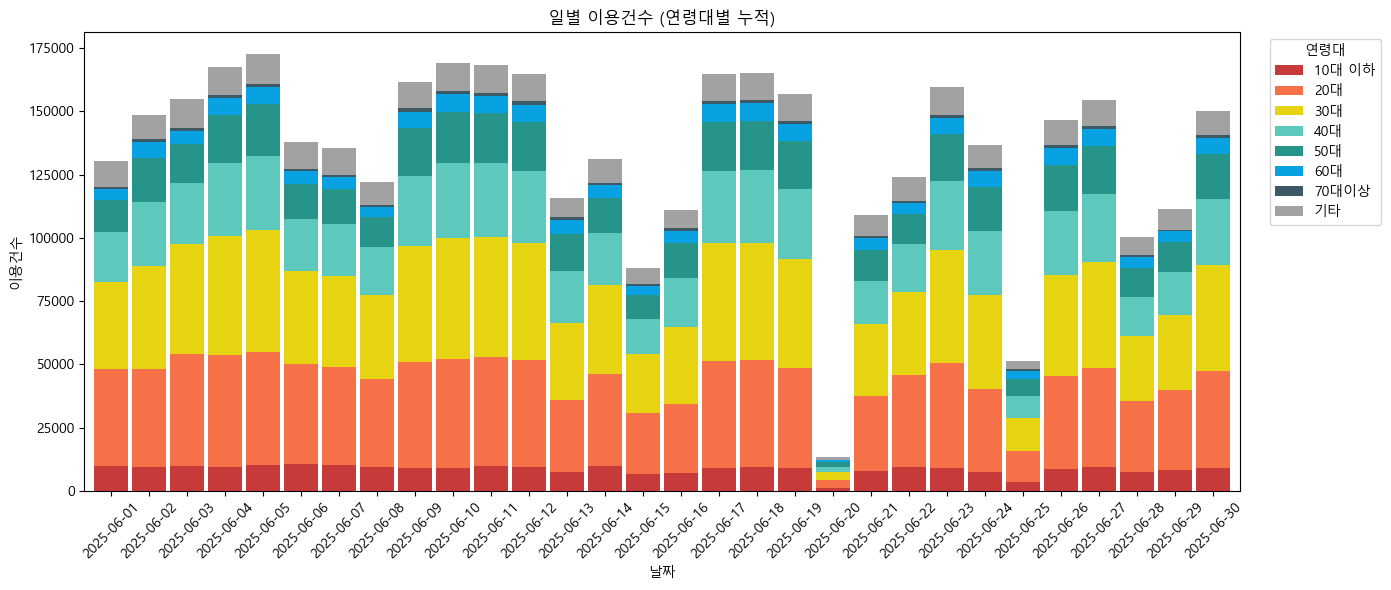

In [ ]:
x_col = "date"
y_col = "age"
count_col = "rentals"

df[x_col] = pd.to_datetime(df[x_col], errors="coerce")

# ===== 일별×연령대 집계 =====
daily_age = (
    df
    .groupby([df[x_col].dt.date, y_col])[count_col]
    .sum()
    .unstack(y_col, fill_value=0)
)

ax = daily_age.plot(kind="bar", stacked=True, figsize=(14, 6), width=0.9, color=palette[:7]+[palette[9]])
ax.bar_label(bars, labels=[f"{v:,}" for v in daily["rentals"]], padding=3, fontsize=8)
ax.set_title("일별 이용건수 (연령대별 누적)")
ax.set_xlabel("날짜")
ax.set_ylabel("이용건수")
ax.tick_params(axis="x", rotation=45)

ax.legend(title="연령대", bbox_to_anchor=(1.02, 1), loc="upper left")

plt.tight_layout()
plt.show()

20대와 30대 이용자가 가장 많은 것을 알 수 있다. 6월 20일과 6월 25일에는 전국적인 장마로 인해 이용자 수가 적었다.

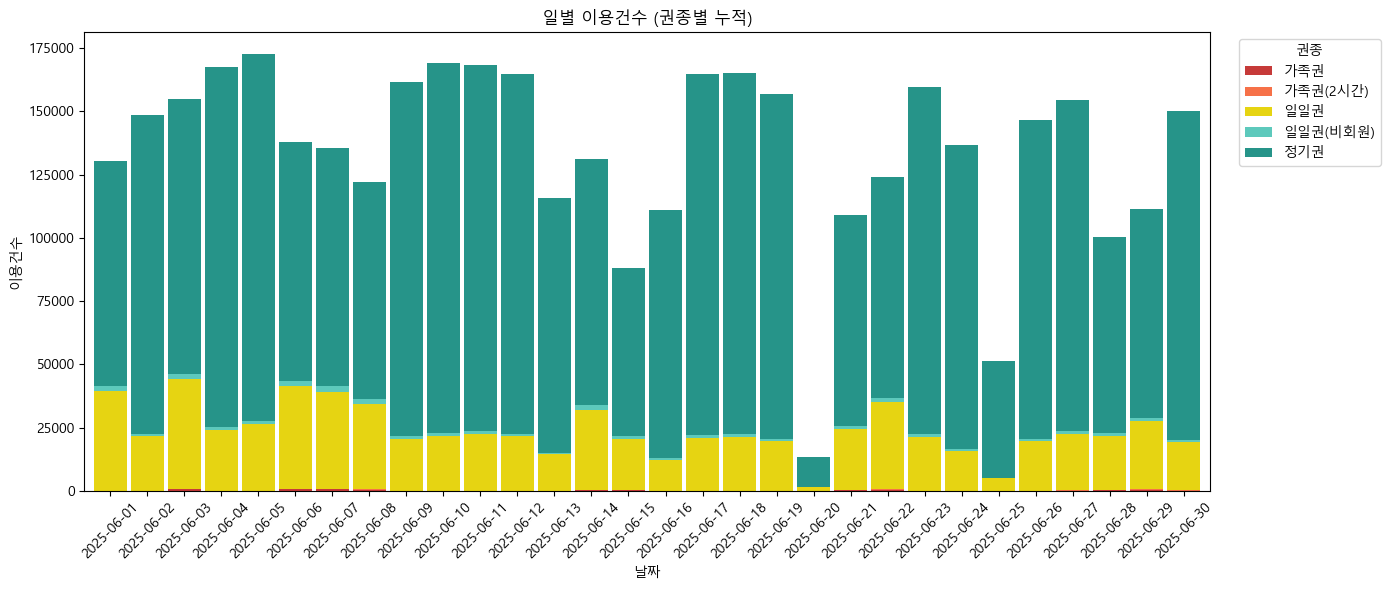

In [ ]:
# ===== 권종별 이용건수 =====
x_col = "date"
y_col = "rental_type"
count_col = "rentals"

df[x_col] = pd.to_datetime(df[x_col], errors="coerce")

# ===== 일별×권종 집계 =====
daily_age = (
    df
    .groupby([df[x_col].dt.date, y_col])[count_col]
    .sum()
    .unstack(y_col, fill_value=0)
)

ax = daily_age.plot(kind="bar", stacked=True, figsize=(14, 6), width=0.9, color=palette[:7]+[palette[9]])
ax.bar_label(bars, labels=[f"{v:,}" for v in daily["rentals"]], padding=3, fontsize=8)
ax.set_title("일별 이용건수 (권종별 누적)")
ax.set_xlabel("날짜")
ax.set_ylabel("이용건수")
ax.tick_params(axis="x", rotation=45)

ax.legend(title="권종", bbox_to_anchor=(1.02, 1), loc="upper left")

plt.tight_layout()
plt.show()

전체 이용건수 중 정기권의 비중이 매우 높다. 이는 대여 집계가 인원 수 단위가 아닌 이용 건수 단위이기 때문으로,
정기권을 구매한 이용자가 더 많은 이용을 했기 때문으로 보인다.

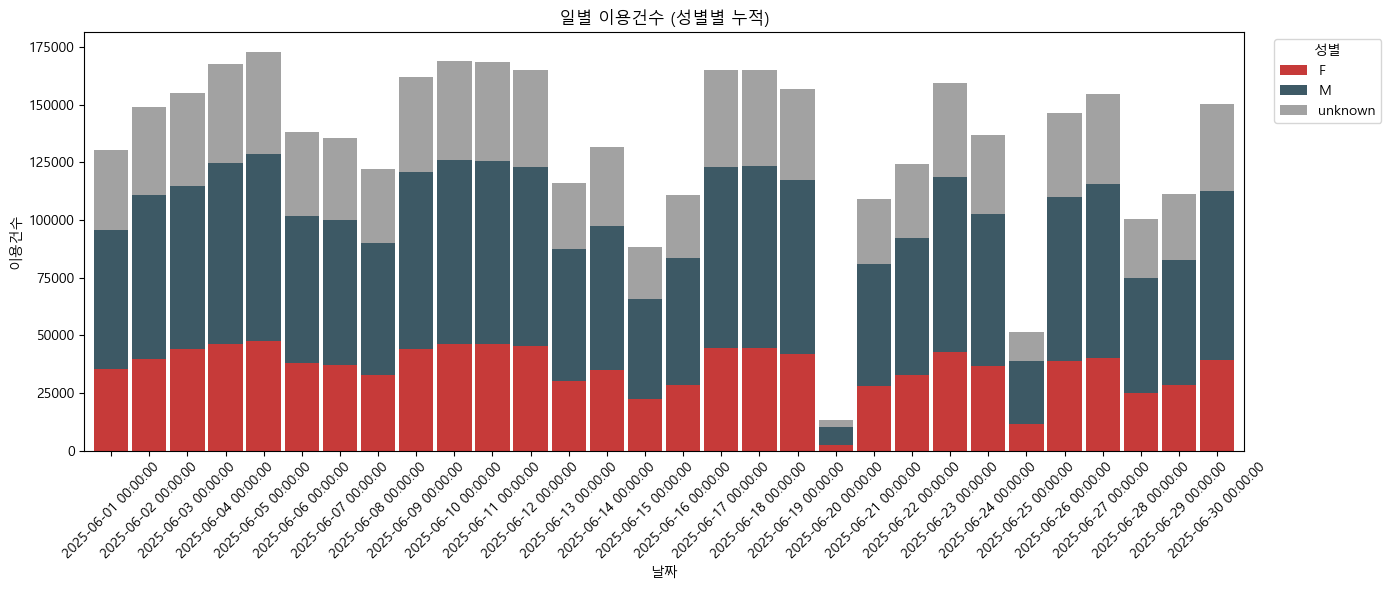

In [ ]:
x_col = "date"
y_col = "gender"
count_col = "rentals"

df[x_col] = pd.to_datetime(df[x_col], errors="coerce")

# ===== 일별×연령대 집계 =====
daily_gender = (
    df
    .groupby([df[x_col], y_col])[count_col]
    .sum()
    .unstack(y_col, fill_value=0)
)

ax = daily_gender.plot(kind="bar", stacked=True, figsize=(14, 6), width=0.9, color=[palette[0], palette[6], palette[9]])
ax.bar_label(bars, labels=[f"{v:,}" for v in daily["rentals"]], padding=3, fontsize=8)
ax.set_title("일별 이용건수 (성별별 누적)")
ax.set_xlabel("날짜")
ax.set_ylabel("이용건수")
ax.tick_params(axis="x", rotation=45)

ax.legend(title="성별", bbox_to_anchor=(1.02, 1), loc="upper left")

plt.tight_layout()
plt.show()

unknown은 비회원으로 이용했거나, 회원가입 후 성별 정보를 입력하지 않은 사람들에 대한 집계이다. 이를 제외하고 보았을 때,
남성이 여성보다 더 많이 이용했음을 알 수 있다.

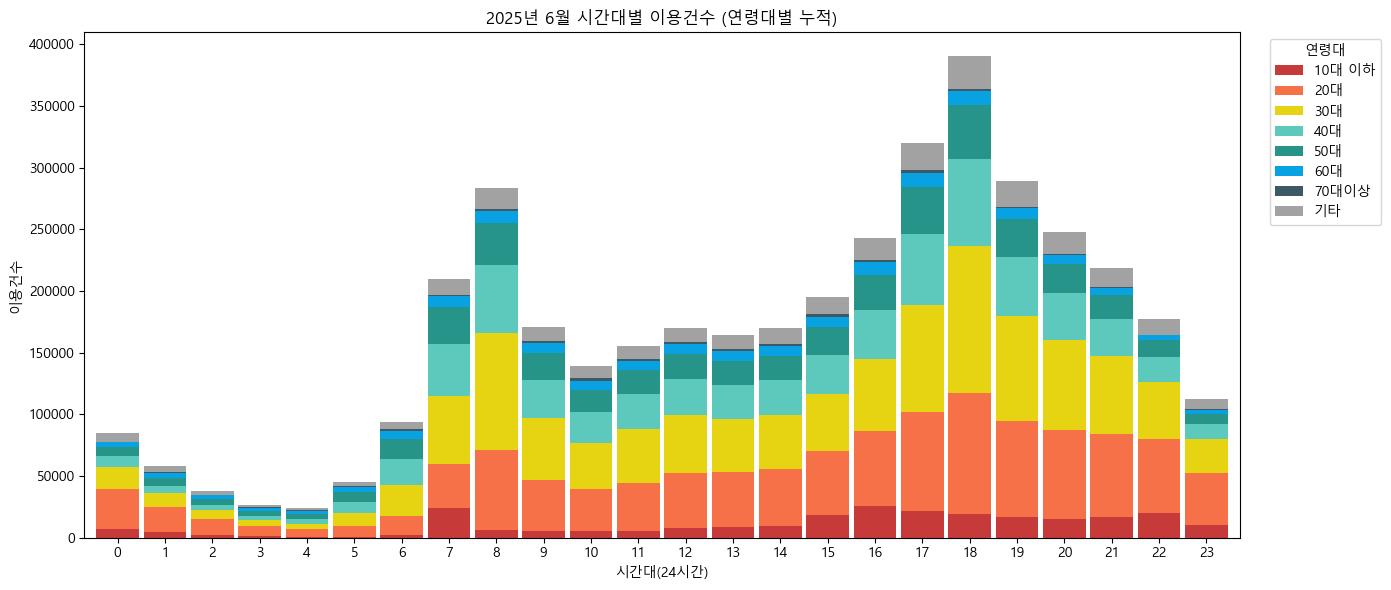

In [ ]:
# ===== 시간대별 이용 건수 =====
x_col = "hour"
y_col = "age"
count_col = "rentals"

# ===== 시간대별x연령대 집계 =====
hour_age = (
    df
    .groupby([df[x_col], y_col])[count_col]
    .sum()
    .unstack(y_col, fill_value=0)
)

ax = hour_age.plot(kind="bar", stacked=True, figsize=(14, 6), width=0.9, color=palette[:7]+[palette[9]])
ax.bar_label(bars, labels=[f"{v:,}" for v in daily["rentals"]], padding=3, fontsize=8)
ax.set_title("2025년 6월 시간대별 이용건수 (연령대별 누적)")
ax.set_xlabel("시간대(24시간)")
ax.set_ylabel("이용건수")
ax.tick_params(axis="x", rotation=0)

ax.legend(title="연령대", bbox_to_anchor=(1.02, 1), loc="upper left")

plt.tight_layout()
plt.show()

출퇴근 시간대, 등하교 시간대인 6시~8시, 17시~19시에 사용자가 급격하게 늘어남을 알 수 있다.
특히 8시 등교를 하는 학교의 경우, 7시~8시 사이와 하교 시간인 16~17시 사이에 10대 이하 이용자의 비중이 늘어나는 것을 확인할 수 있다.
또한, 많은 학원은 22시에 종료되는데, 이 시간대에도 따릉이 이용자 수가 늘어나는 것을 확인할 수 있다.
직장인의 경우, 9시까지 출근하는 경우가 가장 많으므로 8시~9시 사이에는 20대~30대 이용자 비중이 매우 높다.

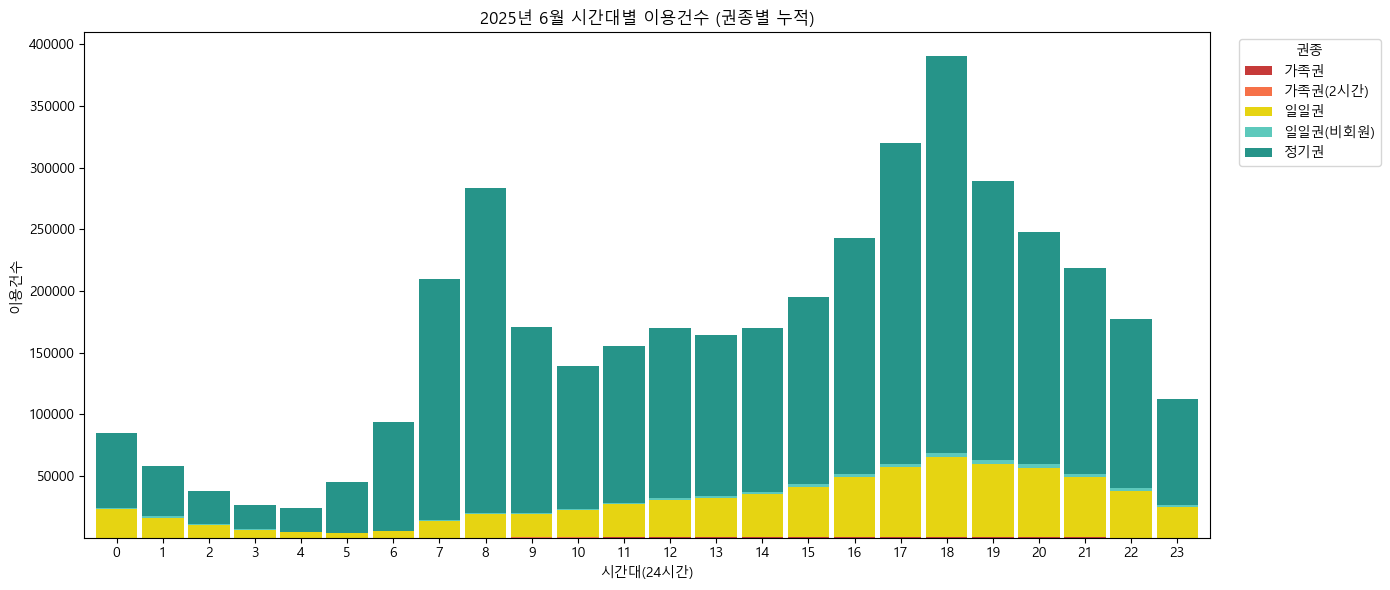

In [ ]:
# ===== 시간대별 이용 건수 =====
x_col = "hour"
y_col = "rental_type"
count_col = "rentals"

# ===== 시간대별x성별 집계 =====
hour_type = (
    df
    .groupby([df[x_col], y_col])[count_col]
    .sum()
    .unstack(y_col, fill_value=0)
)

ax = hour_type.plot(kind="bar", stacked=True, figsize=(14, 6), width=0.9, color=palette[:7]+[palette[9]])
ax.bar_label(bars, labels=[f"{v:,}" for v in daily["rentals"]], padding=3, fontsize=8)
ax.set_title("2025년 6월 시간대별 이용건수 (권종별 누적)")
ax.set_xlabel("시간대(24시간)")
ax.set_ylabel("이용건수")
ax.tick_params(axis="x", rotation=0)

ax.legend(title="권종", bbox_to_anchor=(1.02, 1), loc="upper left")

plt.tight_layout()
plt.show()

일일권 사용자의 시간대에 따른 이용건수 변화보다, 정기권 사용자의 시간대에 따른 이용건수 변화가 압도적으로 크다.
이는 고정적으로 출·퇴근, 등·하교를 따릉이를 이용해서 하는 사람들이 많다는 것을 암시한다.

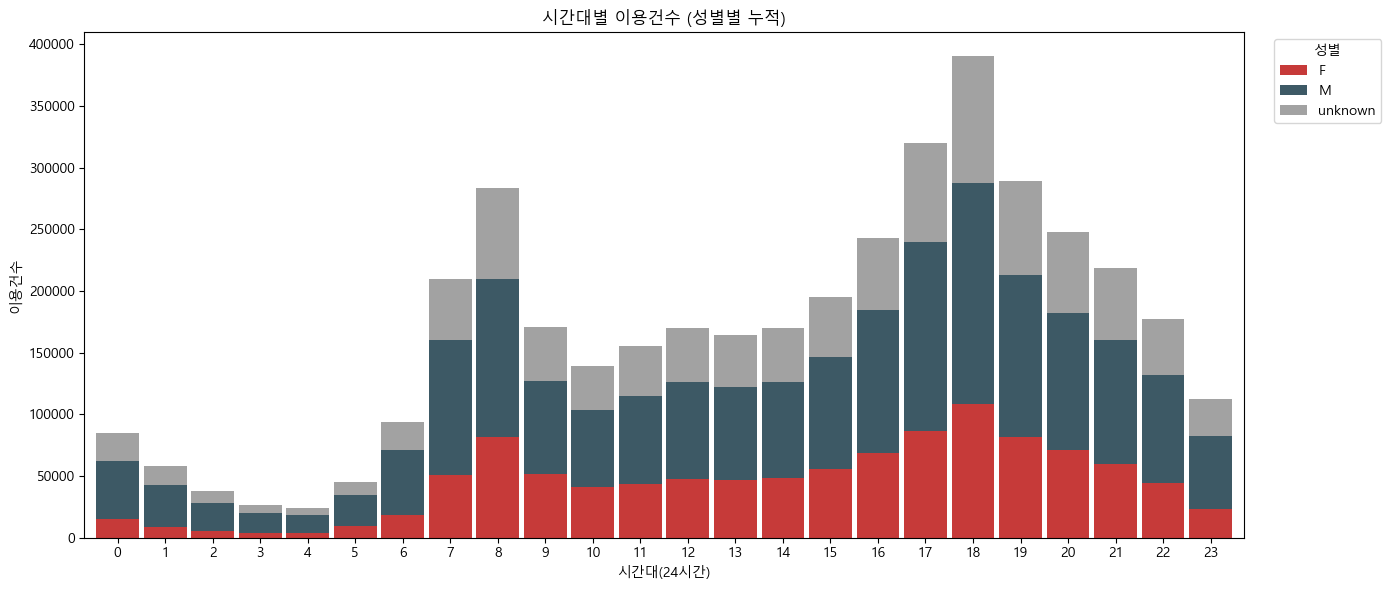

In [ ]:
# ===== 시간대별 이용 건수 =====
x_col = "hour"
y_col = "gender"
count_col = "rentals"

# ===== 시간대별x성별 집계 =====
hour_gender = (
    df
    .groupby([df[x_col], y_col])[count_col]
    .sum()
    .unstack(y_col, fill_value=0)
)

ax = hour_gender.plot(kind="bar", stacked=True, figsize=(14, 6), width=0.9, color=[palette[0], palette[6], palette[9]])
ax.bar_label(bars, labels=[f"{v:,}" for v in daily["rentals"]], padding=3, fontsize=8)
ax.set_title("시간대별 이용건수 (성별별 누적)")
ax.set_xlabel("시간대(24시간)")
ax.set_ylabel("이용건수")
ax.tick_params(axis="x", rotation=0)

ax.legend(title="성별", bbox_to_anchor=(1.02, 1), loc="upper left")

plt.tight_layout()
plt.show()

새벽 시간대 00시~06시 사이에는 전체 사용자 중 남성의 비율이 다른 어떤 시간대보다도 높다. 이는 남성이 평균적으로 야간·철야 근무를 여성보다 많이 하기 때문일 것으로 예상된다.
또한 그 외의 시간대에서는 남성 사용자의 비중이 여성보다 전 구간에서 약간 더 많은데, 이는 남성이 상대적으로 자전거를 타는 일을 힘들지 않은 일로 생각하고 행동하는 경향성이 일부 반영된 것으로 보인다.

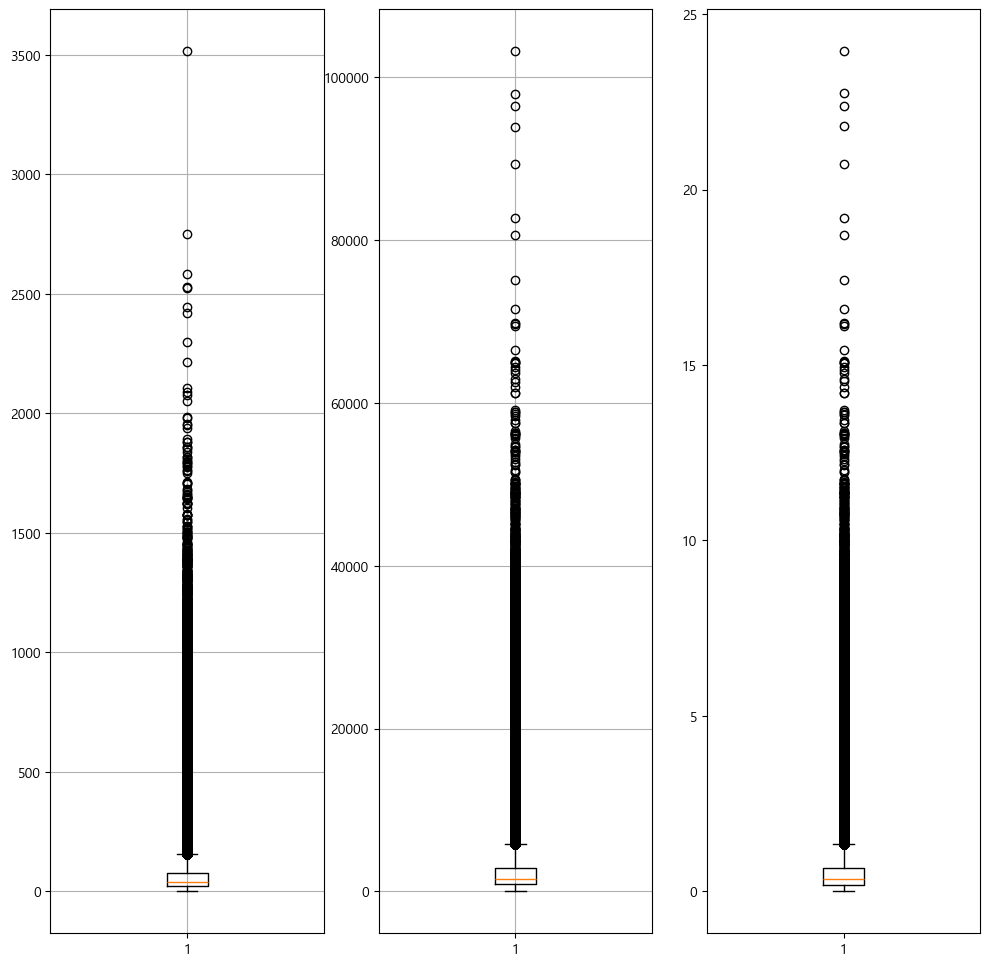

In [ ]:
# ===== 대여 당 운동량, 탄소량, 이동거리 ===== 
per_cal = time['calories']/time['rentals']
per_dist = time['distance']/time['rentals']
per_carbon = time['carbon_reduction']/time['rentals']
plt.figure(figsize=(12, 12))
plt.subplot(1, 3, 1)
plt.boxplot(per_cal)
plt.grid()
plt.subplot(1, 3, 2)
plt.boxplot(per_dist)
plt.grid()
plt.subplot(1, 3, 3)
plt.boxplot(per_carbon)
plt.show()

In [40]:
# 이동거리와 탄소감축량의 상관관계 확인
spst.pearsonr(per_dist, per_carbon)
# r값이 0.9969이므로 탄소감축량을 별도로 분석할 필요가 없다

PearsonRResult(statistic=np.float64(0.996912875377327), pvalue=np.float64(0.0))

In [41]:
# 이동거리와 운동량의 상관관계 확인
spst.pearsonr(per_dist, per_cal)
# r값이 0.9716이므로 거의 이동거리에 의해서 운동량이 결정된다고 이야기할 수 있음

PearsonRResult(statistic=np.float64(0.9716003403470106), pvalue=np.float64(0.0))

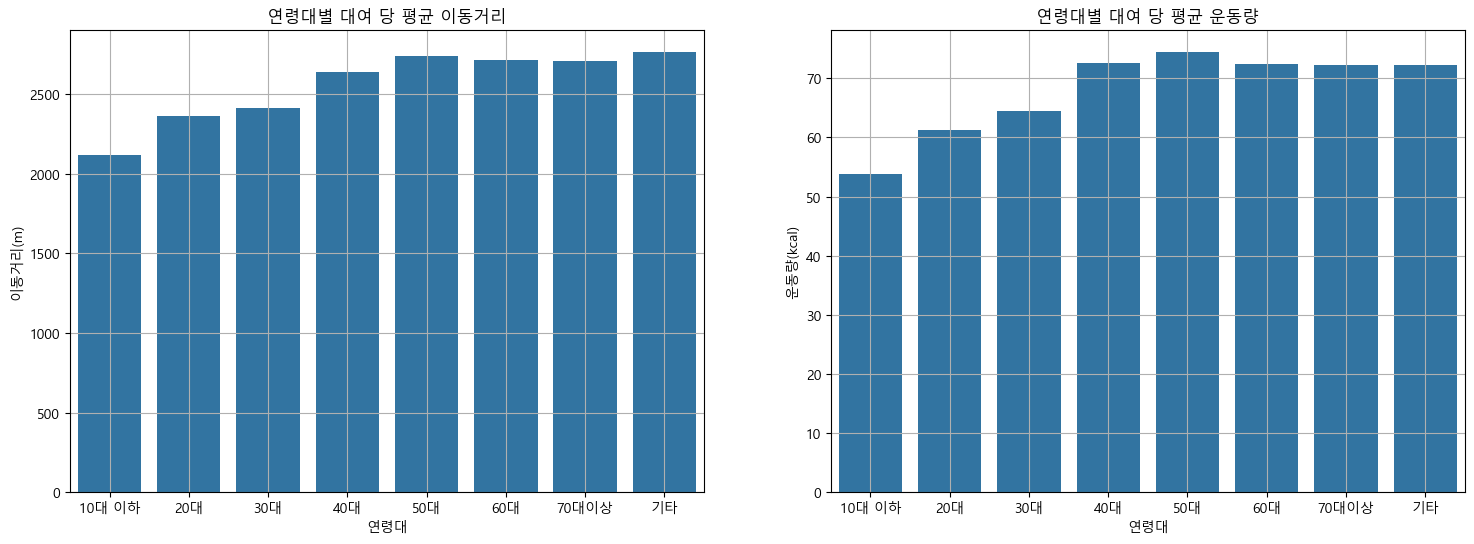

In [42]:
# 연령대별 평균 이동거리, 운동량 확인
age_mean_dist = (
    time.groupby("age")[["calories", "distance", "rentals"]]
        .sum()
        .assign(mean_dist=lambda d: d["distance"] / d["rentals"])
        .assign(mean_cal=lambda d: d["calories"] / d["rentals"])
        .reset_index()
)
plt.figure(figsize=(18, 6))
plt.subplot(1, 2, 1)
sns.barplot(data=age_mean_dist, x="age", y="mean_dist")
plt.title("연령대별 대여 당 평균 이동거리")
plt.xlabel("연령대")
plt.ylabel("이동거리(m)")
plt.grid()
plt.subplot(1, 2, 2)
sns.barplot(data=age_mean_dist, x="age", y="mean_cal")
plt.title("연령대별 대여 당 평균 운동량")
plt.xlabel("연령대")
plt.ylabel("운동량(kcal)")
plt.grid()
plt.show()


운동량은 주행 거리, 이용 시간, 몸무게 등이 함께 고려되어 측정된다.
평균 이동거리는 고령층으로 갈수록 조금씩 증가하는 것을 확인할 수 있다.
이는 운동을 위해서 따릉이를 이용하는 비중이 20~30대보다 40~50대 층에서 더 많기 때문일 것이라고 예상해볼 수 있다.
또한 상대적으로 느린 주행을 하는 60대와 70대 이상 사용자들은 이동거리에 비해 운동량이 40대~50대 사용자보다 더 작다.

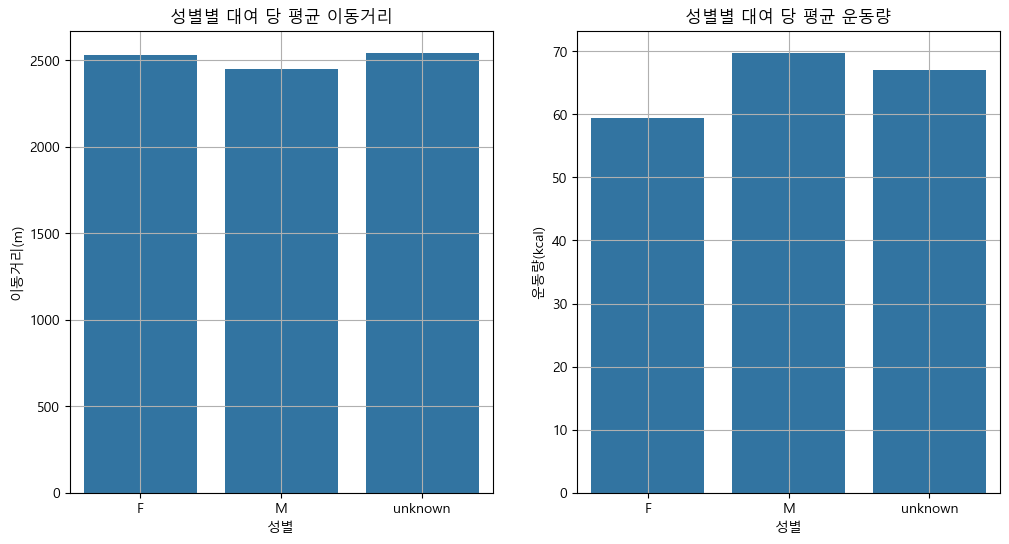

In [43]:
# 성별별 평균 이동거리, 운동량 확인
gender_mean_dist = (
    time.groupby("gender")[["calories", "distance", "rentals"]]
        .sum()
        .assign(mean_dist=lambda d: d["distance"] / d["rentals"])
        .assign(mean_cal=lambda d: d["calories"] / d["rentals"])
        .reset_index()
)

plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
sns.barplot(data=gender_mean_dist, x="gender", y="mean_dist")
plt.title("성별별 대여 당 평균 이동거리")
plt.xlabel("성별")
plt.ylabel("이동거리(m)")
plt.grid()
plt.subplot(1, 2, 2)
sns.barplot(data=gender_mean_dist, x="gender", y="mean_cal")
plt.title("성별별 대여 당 평균 운동량")
plt.xlabel("성별")
plt.ylabel("운동량(kcal)")
plt.grid()
plt.show()


이동거리는 여성과 남성이 비슷했고, 오히려 여성의 평균 이동거리가 남성보다 높았다.
반대로 대여 당 평균 운동량은 남성이 여성보다 더 높은데, 이는 남성의 평균 체중이 여성보다 높고 주행속도가 빠르기 때문일 것이다.

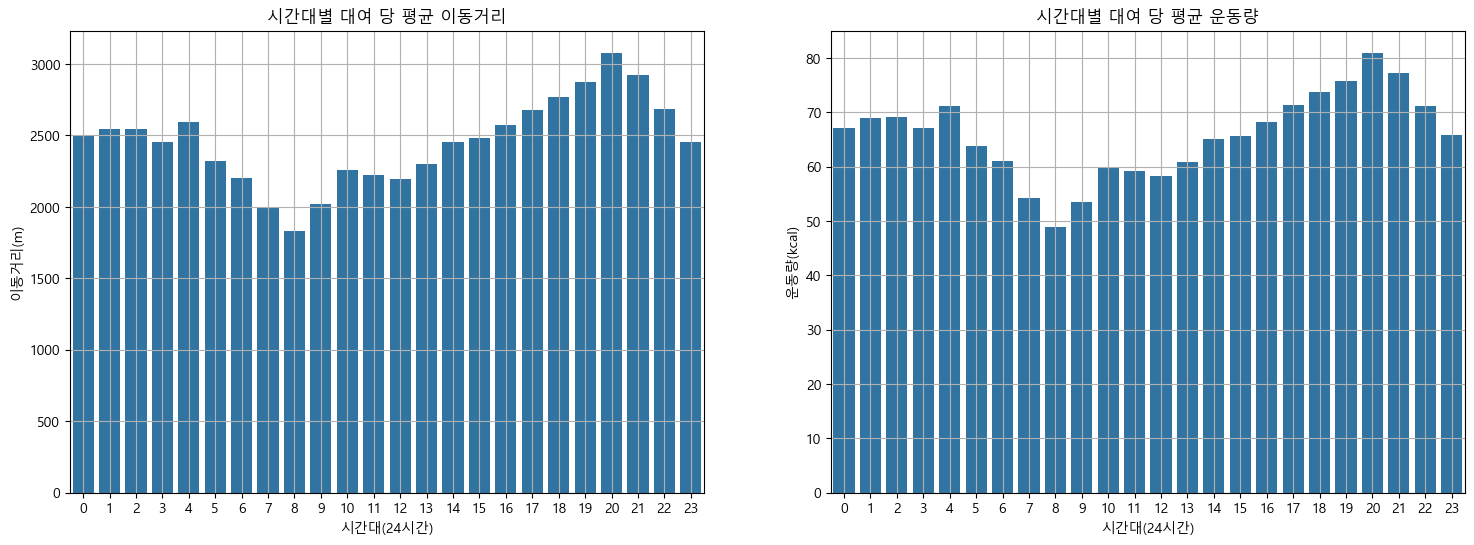

In [44]:
# 시간대별 평균 이동거리, 운동량 확인
hour_mean_dist = (
    time.groupby("hour")[["calories", "distance", "rentals"]]
        .sum()
        .assign(mean_dist=lambda d: d["distance"] / d["rentals"])
        .assign(mean_cal=lambda d: d["calories"] / d["rentals"])
        .reset_index()
)

plt.figure(figsize=(18, 6))
plt.subplot(1, 2, 1)
sns.barplot(data=hour_mean_dist, x="hour", y="mean_dist")
plt.title("시간대별 대여 당 평균 이동거리")
plt.xlabel("시간대(24시간)")
plt.ylabel("이동거리(m)")
plt.grid()
plt.subplot(1, 2, 2)
sns.barplot(data=hour_mean_dist, x="hour", y="mean_cal")
plt.title("시간대별 대여 당 평균 운동량")
plt.xlabel("시간대(24시간)")
plt.ylabel("운동량(kcal)")
plt.grid()
plt.show()


출근, 등교 시간대인 7시~9시는 평균 이동거리가 짧았다. 작은 거리를 자주 이용하는 대여의 비중이 높기 때문일 것으로 예상된다.
이와는 반대로 퇴근 시간대에는 오히려 출근, 등교시간대와 다르게 평균 이동거리가 높은데, 이는 저녁에 운동을 목적으로
따릉이를 이용하는 사용자가 늘어나고, 여가를 위한 이동으로 따릉이를 이용하는 사용자들이 많기 때문일 것이라고 예상한다.

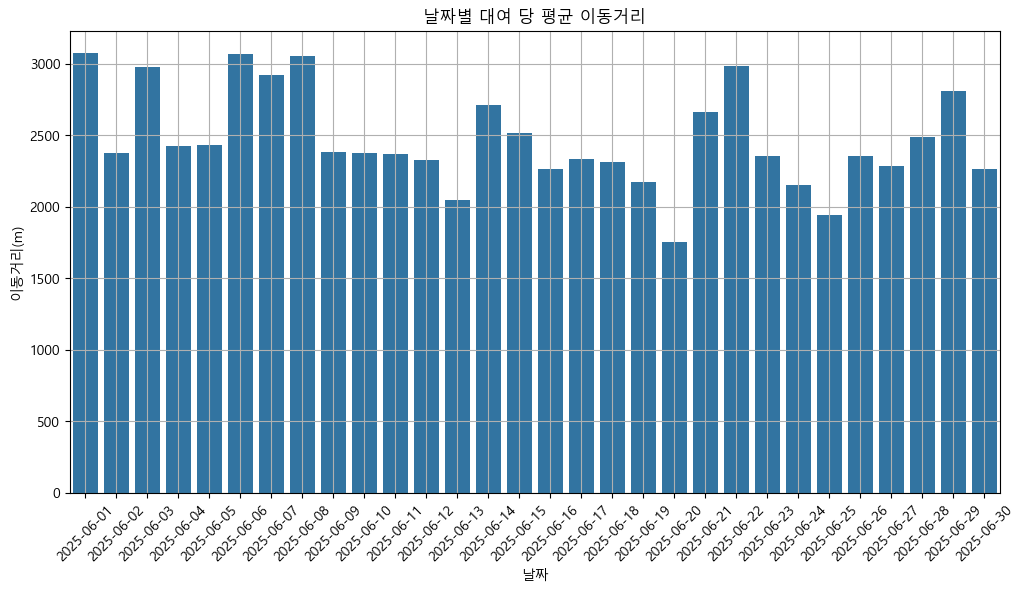

In [45]:
# 날짜별 평균 이동거리 확인
date_mean_dist = (
    time.groupby("date")[["distance", "rentals"]]
        .sum()
        .assign(mean_dist=lambda d: d["distance"] / d["rentals"])
        .reset_index()
)
plt.figure(figsize=(12, 6))
sns.barplot(data=date_mean_dist, x="date", y="mean_dist")
plt.title("날짜별 대여 당 평균 이동거리")
plt.xlabel("날짜")
plt.xticks(rotation=45)
plt.ylabel("이동거리(m)")
plt.grid()
plt.show()
# 주말에 여가 및 운동삼아 따릉이를 이용하는 사람이 많아서 평균 이동거리가 높음

폭우가 내렸던 6월 20일과 6월 25일의 경우, 다른 날에 비해 평균 이동거리가 확실히 짧은 것을 알 수 있다.
또한 주말은 2025년 6월 기준 7, 8, 14, 15, 21, 22, 28, 29일이다.
주말에는 평일에 비해 평균 이동거리가 높은 것을 알 수 있다.
이는 주말에 이동이 아닌 운동, 여가를 목적으로 따릉이를 이용하는 사용자의 비중이 높아지기 때문일 것으로 예상한다.

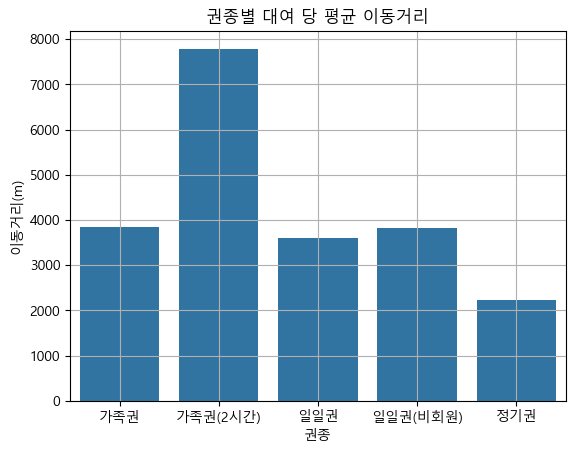

In [46]:
# 권종별 평균 이동거리 확인
type_mean_dist = (
    time.groupby("rental_type")[["distance", "rentals"]]
        .sum()
        .assign(mean_dist=lambda d: d["distance"] / d["rentals"])
        .reset_index()
)
sns.barplot(data=type_mean_dist, x="rental_type", y="mean_dist")
plt.title("권종별 대여 당 평균 이동거리")
plt.xlabel("권종")
plt.ylabel("이동거리(m)")
plt.grid()
plt.show()

가족권(2시간)의 경우, 일반 가족권보다 대여 당 평균 이동거리가 약 2배 높았다. 이는 일반 가족권의 이용시간이 1시간이기 때문이다.
또한 정기권의 경우 다른 권종 그룹에 비해 이동거리가 확연히 낮은데, 이는 정기권 구매 시 짧은 거리를 반복적으로 이용하는 경우가 많아지기 때문이다.
일일권을 구매하면 짧은 거리/짧은 시간 이용 시 손해를 보게 되는 심리를 사용자들이 느끼지만, 정기권의 경우는 그렇지 않기 때문이다.

In [47]:
pd.crosstab(
    index=df["age"],
    columns=df["rental_type"],
    values=df["rentals"],
    aggfunc="sum",
    dropna=False
).fillna(0)


rental_type,가족권,가족권(2시간),일일권,일일권(비회원),정기권
age,,,,,
10대 이하,4671.0,1906.0,72956.0,5.0,175808.0
20대,46.0,16.0,267814.0,141.0,795068.0
30대,1.0,0.0,186973.0,31.0,914957.0
40대,5.0,3.0,83176.0,12.0,587343.0
50대,0.0,0.0,33830.0,11.0,427167.0
60대,0.0,0.0,7791.0,1.0,156076.0
70대이상,0.0,0.0,1432.0,0.0,28899.0
기타,0.0,0.0,50501.0,35579.0,192030.0


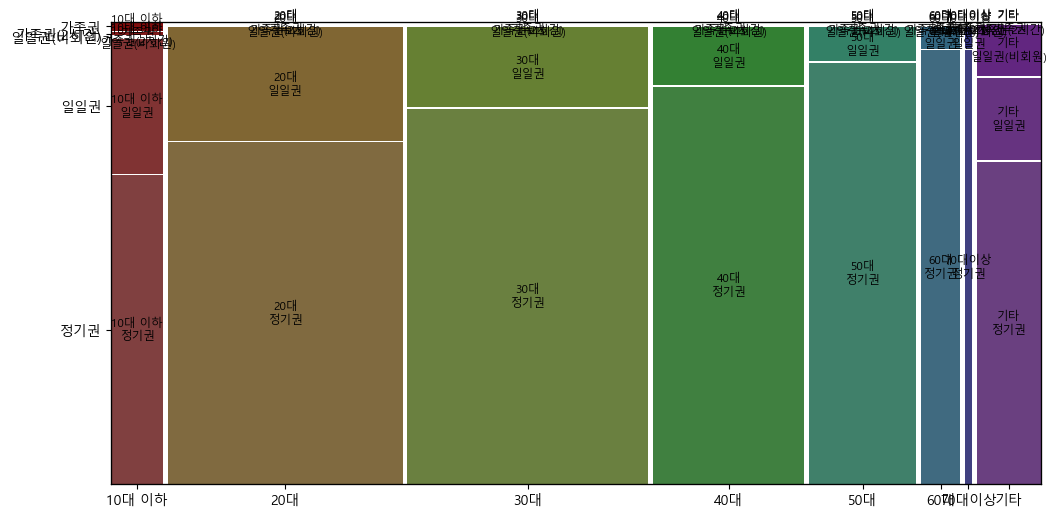

In [48]:
# 연령대별 이용 권종
fig, ax = plt.subplots(figsize=(12, 6))
mosaic(time, ['age', 'rental_type'], ax=ax)
plt.show()

따릉이의 대여건수 중 정기권이 차지하는 비중은 연령대가 높아질수록 커졌다.
이는 운동을 하지 않거나 자전거를 탈 정도의 건강상태와는 거리가 있는 사용자들은 일일권을 구매할 일이 잘 없기 때문일 것으로 보인다.
반면 청소년 및 청년층은 1회성으로 따릉이를 교통수단으로 인식하고 선택하는 비중이 훨씬 큰 것을 알 수 있다. 

In [ ]:
# 날짜 및 시간대별 이용건수 히트맵
date_col = "date"
hour_col = "hour"
count_col = "rentals"

df["day"] = df[date_col]

heat = df.pivot_table(
    index="day",
    columns=hour_col,
    values=count_col,
    aggfunc="sum",
    fill_value=0
)

# 0~23 시간대 컬럼이 빠짐없이 나오게 고정
heat = heat.reindex(columns=range(24), fill_value=0)

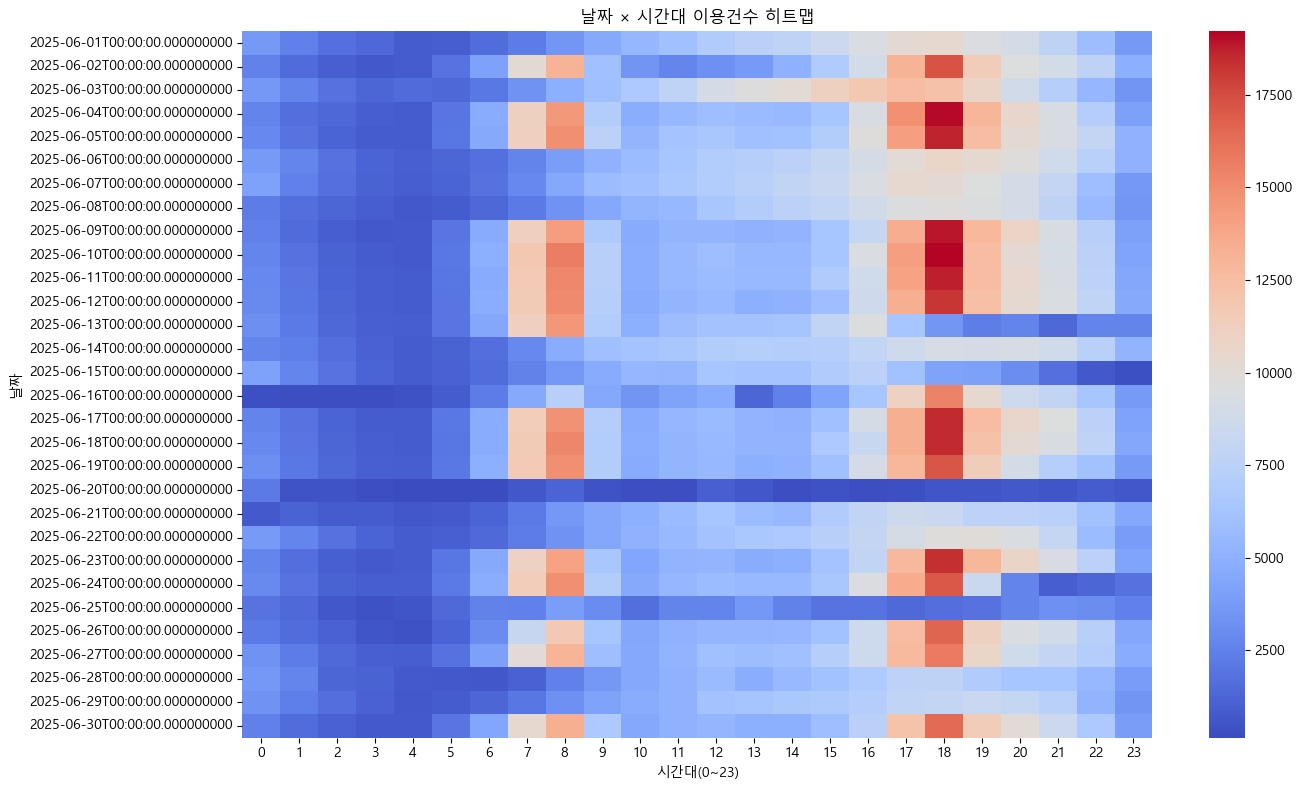

In [ ]:
plt.figure(figsize=(14, 8))
sns.heatmap(heat, cmap="coolwarm")
plt.title("날짜 × 시간대 이용건수 히트맵")
plt.xlabel("시간대(0~23)")
plt.ylabel("날짜")
plt.tight_layout()
plt.show()
# 평일에만 출퇴근대 이용건수가 매우 높은 것을 알 수 있다.
# 또한 일반적인 이용패턴과 다른 경우, 날씨가 영향을 주는 경우가 많다.

날짜별, 시간대별로 따릉이 이용건수를 시각화한 그림이다. 주말인 7, 8, 14, 15, 21, 22, 28, 29일에는 출퇴근 시간대의 사용량이 평일보다
현저히 적은 것을 알 수 있다.
6월 20일 외에도, 6월 13일, 6월 25일 등은 평일임에도 불구하고 이용량이 급격히 떨어졌는데, 우천의 영향이 작용했음을 알 수 있다.

In [56]:
df_district = df.merge(
    stations[["station_id", "gu"]],
    on = "station_id",
    how= "left"
)

In [74]:
# 자치구별 인구수
population = {
    "강남구"    : 562382,
    "강동구"    : 503987,
    "강북구"    : 286607,
    "강서구"    : 557177,
    "관악구"    : 497998,
    "광진구"    : 349963,
    "구로구"    : 409707,
    "금천구"    : 237847,
    "노원구"    : 490739,
    "도봉구"    : 303770,
    "동대문구"  : 364828,
    "동작구"    : 385786,
    "마포구"    : 370471,
    "서대문구"  : 147373,
    "서초구"    : 417288,
    "성동구"    : 282288,
    "성북구"    : 437922,
    "송파구"    : 652094,
    "양천구"    : 430045,
    "영등포구"  : 396202,
    "용산구"    : 215716,
    "은평구"    : 461842,
    "종로구"    : 149165,
    "중구"      : 128942,
    "중랑구"    : 383737,
}

In [ ]:
# 자치구별 일별 이용량
x_col = "date"
y_col = "gu"
count_col = "rentals"

df_district["date"] = df[x_col]

heat = df_district.pivot_table(
    index="gu",
    columns=x_col,
    values=count_col,
    aggfunc="sum",
    fill_value=0
)

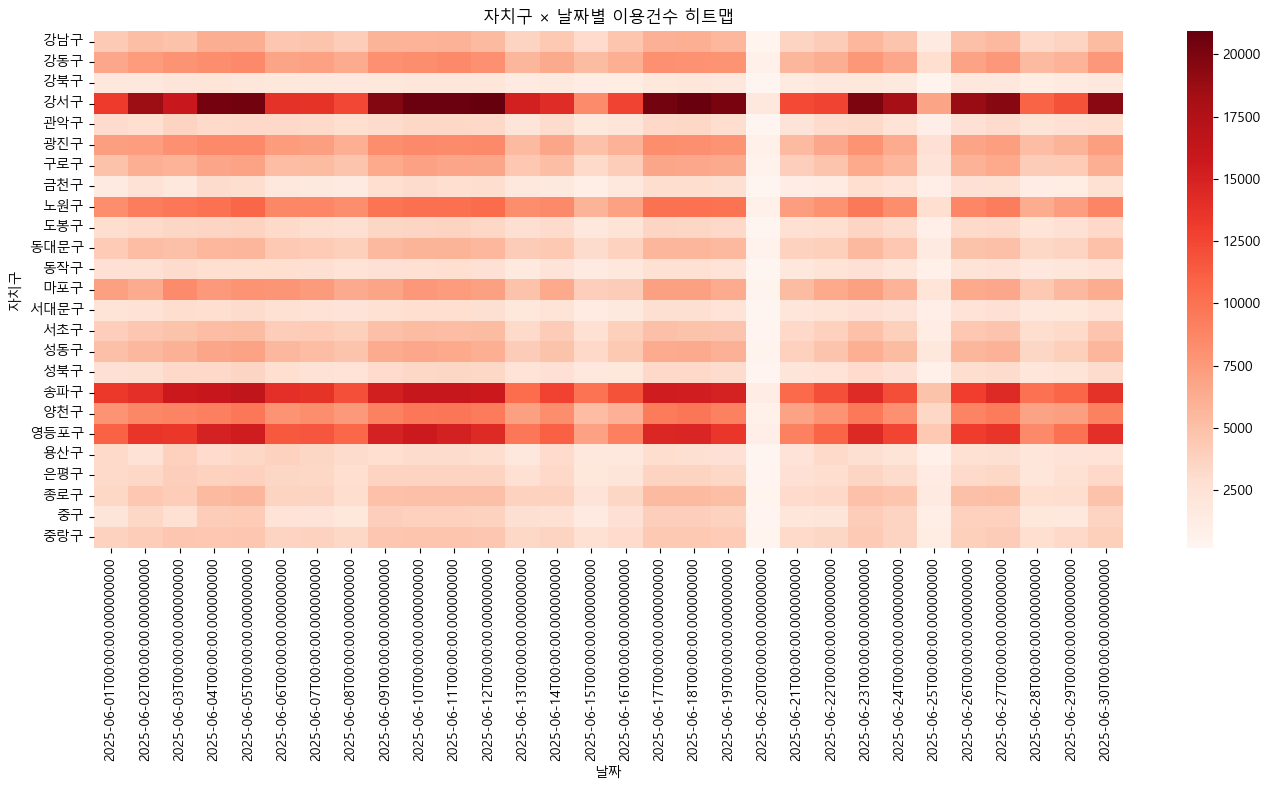

In [ ]:
plt.figure(figsize=(14, 8))
sns.heatmap(heat, cmap="Reds")
plt.title("자치구 × 날짜별 이용건수 히트맵")
plt.xlabel("날짜")
plt.ylabel("자치구")
plt.tight_layout()
plt.show()

자치구별, 날짜별 이용량 통계이다. 대체로 인구수가 높은 자치구가 사용량도 당연하게 높다.

In [ ]:
district_col = "gu"
count_col = "rentals"

# ===== 자치구별 이용건수 합 =====
usage_by_dist = (
    df_district.groupby(district_col)[count_col]
      .sum()
      .rename("rentals_total")
      .to_frame()
)

# ===== 인구 매핑 =====
usage_by_dist["population"] = usage_by_dist.index.map(population)

# ===== 1인당 이용량 (per capita) =====
usage_by_dist["rentals_per_person"] = usage_by_dist["rentals_total"] / usage_by_dist["population"]

# ===== 1000명당 이용량 =====
usage_by_dist["rentals_per_1000"] = usage_by_dist["rentals_per_person"] * 1000

usage_by_dist.sort_values("rentals_per_1000", ascending=False)


,rentals_total,population,rentals_per_person,rentals_per_1000
gu,,,,
영등포구,354320,396202,0.894291,894.291296
강서구,475094,557177,0.852681,852.680566
종로구,122167,149165,0.819006,819.005799
중구,89386,128942,0.693226,693.226412
송파구,386690,652094,0.592997,592.997329
광진구,203421,349963,0.581264,581.264305
양천구,239484,430045,0.556881,556.881257
성동구,154516,282288,0.547370,547.370062
노원구,251502,490739,0.512496,512.496459


In [ ]:
# 자치구별 시간대별 이용량
x_col = "hour"
y_col = "gu"
count_col = "rentals"

df_district["hour"] = df[x_col]

heat = df_district.pivot_table(
    index="gu",
    columns=x_col,
    values=count_col,
    aggfunc="sum",
    fill_value=0
)

heat = heat.reindex(columns=range(24), fill_value=0)

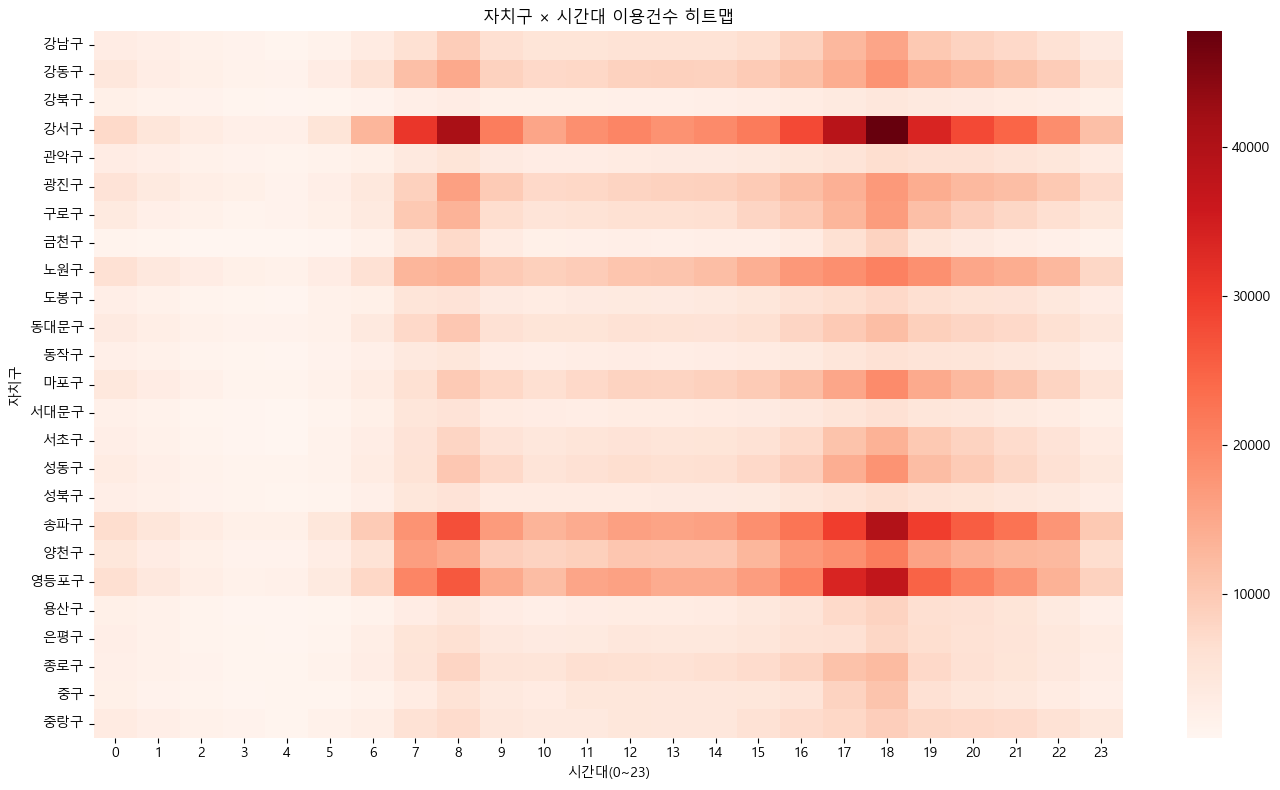

In [ ]:
plt.figure(figsize=(14, 8))
sns.heatmap(heat, cmap="Reds")
plt.title("자치구 × 시간대 이용건수 히트맵")
plt.xlabel("시간대(0~23)")
plt.ylabel("자치구")
plt.tight_layout()
plt.show()
# 대체로 시간대에 상관없이 자치구별 인구수에 비례해서 이용건수가 늘어남.

자치구별 시간대별 사용량에 대한 통계이다. 단, 각 자치구별 이용건수를 자치구별 인구로 나눈 후 1000을 곱한 값이다. 즉 단위 인구수당 이용건수에 대한 통계이다. 
강서구, 송파구, 영등포구는 다른 자치구에 비해 출퇴근 시간대 이용건수가 매우 높은 것을 알 수 있다.
이 부분에 대해서는 대중교통망, 상업지구 비율 등의 지표를 이용해 추가적인 분석을 해보고 싶다.

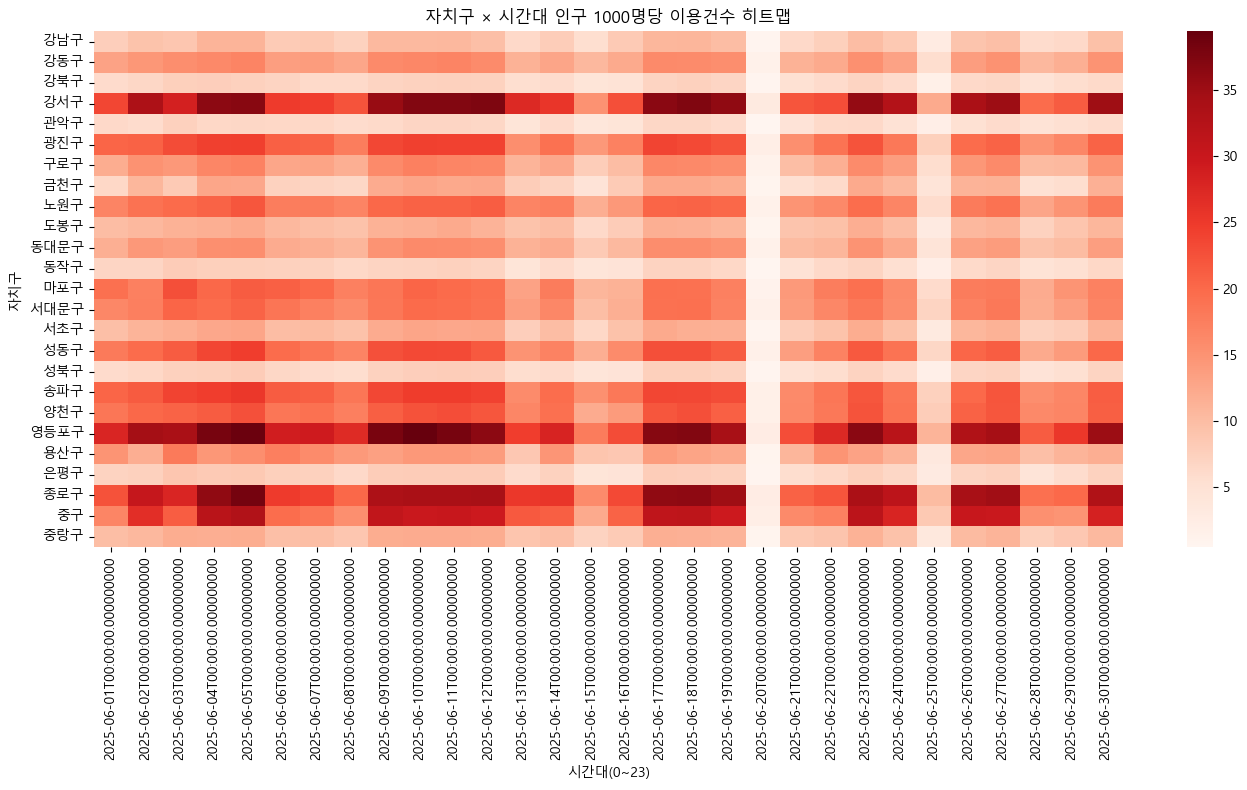

In [ ]:
# 위 히트맵을 자치구별 인구수로 나누어보면
pop_per_1000 = pd.Series(population, name="pop").reindex(heat.index) / 1000
heat_per_1000 = heat.div(pop_per_1000, axis=0)

plt.figure(figsize=(14, 8))
sns.heatmap(heat_per_1000, cmap="Reds")
plt.title("자치구 × 시간대 인구 1000명당 이용건수 히트맵")
plt.xlabel("시간대(0~23)")
plt.ylabel("자치구")
plt.tight_layout()
plt.show()


In [ ]:
# 자치구별 이용 연령대
x_col = "age"
y_col = "gu"
count_col = "rentals"

df_district["age"] = df[x_col]

heat = df_district.pivot_table(
    index="gu",
    columns=x_col,
    values=count_col,
    aggfunc="sum",
    fill_value=0
)

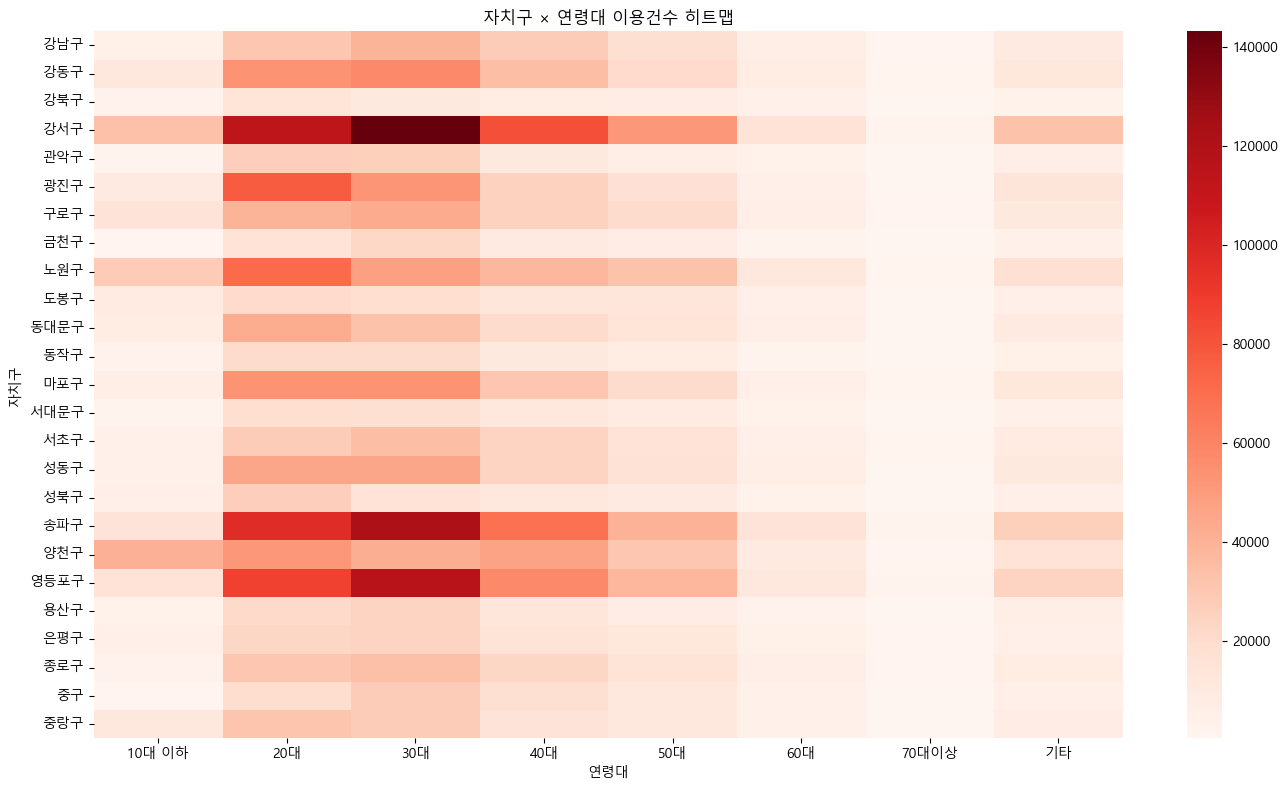

In [ ]:
plt.figure(figsize=(14, 8))
sns.heatmap(heat, cmap="Reds")
plt.title("자치구 × 연령대 이용건수 히트맵")
plt.xlabel("연령대")
plt.ylabel("자치구")
plt.tight_layout()
plt.show()